In [6]:
!rm -rf .models
!mkdir .models
!wget -q -O .models/cifar_linf_8.pt "https://www.dropbox.com/s/yhpp4yws7sgi6lj/cifar_linf_8.pt?dl=1"

In [1]:
import os
import pathlib
import random
import functools
import copy
import sys
import pickle
import tarfile
import operator
import math
import requests
import importlib
os.environ["NOTEBOOK_MODE"] = "1"

import tqdm
import cox

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sklearn
from sklearn import preprocessing
import scipy


import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import torch

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

import flax
import neural_tangents as nt
import art
import robustness
from robustness import model_utils, datasets, train, defaults

import vit_jax

import adversarial_ntks as atk

f:\users\0\main\active\erlija\adversarial-ntks\robustness\robustness\train.py:24: UserWarning: Could not import amp.
  warnings.warn('Could not import amp.')


In [2]:
CIFAR10 = {
    "dataset": robustness.datasets.CIFAR(".data"),
    "workers": 12,
    "arch": "resnet50",
    "resume_path": ".models/cifar_linf_8.pt",
    "labels": ["airplane", "automobile", "bird", "cat", "deer",
        "dog", "frog", "horse", "ship", "truck"],
    
    "train_subset": 512,
    "test_subset": 512,
    "batch_size": 32,
    
    "perturb_target": 3,
    "perturb_eps": 0.02,
    "attack_lr_scaling": 2.5,
    "attack_steps": 20,

    "display_samples": 10,
    "display_sample_img_size": 3}

In [3]:
def exp_make_loaders(exp):
    exp["train_loader"], exp["val_loader"] = exp["dataset"].make_loaders(
        batch_size=exp["batch_size"],
        subset=exp["train_subset"],
        test_subset=exp["test_subset"],
        workers=exp["workers"])

exp_make_loaders(CIFAR10)

==> Preparing dataset cifar..
Files already downloaded and verified
Files already downloaded and verified


In [4]:
def exp_load_saved(exp):
    exp["model"], _ = model_utils.make_and_restore_model(
        arch=exp["arch"],
        resume_path=exp["resume_path"],
        dataset=exp["dataset"])
    exp["model"].eval()

exp_load_saved(CIFAR10)

=> loading checkpoint '.models/cifar_linf_8.pt'
=> loaded checkpoint '.models/cifar_linf_8.pt' (epoch 190)


In [5]:
def exp_eval(exp):
    exp.update({
        "eval_args": defaults.check_and_fill_args(
            args=cox.utils.Parameters({
                "adv_eval": 1,
                "out_dir": ".results",
                "constraint": "inf",
                "eps": exp["perturb_eps"],
                "attack_lr": exp["attack_lr_scaling"] * exp["perturb_eps"] / exp["attack_steps"],
                "attack_steps": exp["attack_steps"]}),
            arg_list=defaults.PGD_ARGS,
            ds_class=datasets.CIFAR),
        "cox": cox.store.Store(".cox")})
    exp["model"].eval()
    exp["eval_results"] = train.eval_model(
        model=exp["model"],
        args=exp["eval_args"],
        loader=exp["val_loader"],
        store=exp["cox"])
    print(exp["eval_results"])

exp_eval(CIFAR10)

Logging in: c:\Users\0\main\active\erlija\adversarial-ntks\notebooks\uniform-e-balls\.cox\a0e658bf-6784-4715-a0d6-916aa1dcc135


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

{'epoch': 0, 'nat_prec1': tensor(95.5078, device='cuda:0'), 'adv_prec1': tensor(0., device='cuda:0'), 'nat_loss': 0.19002599063242087, 'adv_loss': 23.244738817214966, 'train_prec1': nan, 'train_loss': nan, 'time': 195.49970149993896}


In [5]:
SAMPLES = 100

CIFAR10["model"].eval()
hist_dat = []
with torch.no_grad():
    for batch in CIFAR10["val_loader"]:
        # print(len(batch), batch[0].shape, batch[1].shape)
        # 2 (32, 3, 32, 32) (32,)

        total_c_batch = np.zeros(batch[1].shape)
        for sample in range(SAMPLES):
            # Uniform perturbance.
            in_cpu = batch[0] + \
                torch.rand(*batch[0].shape) * CIFAR10["perturb_eps"] * 2 - \
                CIFAR10["perturb_eps"]

            out = CIFAR10["model"](in_cpu.cuda())
            out_cpu = (out[0].cpu(), out[1].cpu())
            # print(pred[0].shape, pred[1].shape)
            # (32, 10), (32, 3, 32, 32)
            pred_classes = np.array([probs.argmax().item()
                for probs in out_cpu[0]])
            correctness = np.equal(pred_classes, np.array(batch[1].tolist()))
            total_c_batch += correctness
        hist_dat.append(1 - total_c_batch / SAMPLES)
        print(1 - total_c_batch / SAMPLES)

[0.   0.   0.   0.22 0.   0.   0.47 0.   0.   0.   0.   0.   0.   0.
 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.  ]
[0.01 0.   0.   1.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.01 0.   0.   0.
 0.   0.   0.   0.  ]
[0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.03 0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.  ]
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.54 0.
 0.   0.   0.   0.06]
[1.   0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.4  0.
 0.   0.   0.   0.2  0.   0.   0.   0.   0.   0.   0.06 0.   0.   1.
 0.   0.   0.   0.  ]
[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.02 0.   0.   0.  ]
[0.   0.   0.   0.17 0.   0.   0.   0.  

In [6]:
# print(hist_dat)
data = np.concatenate(hist_dat)
# print(data)

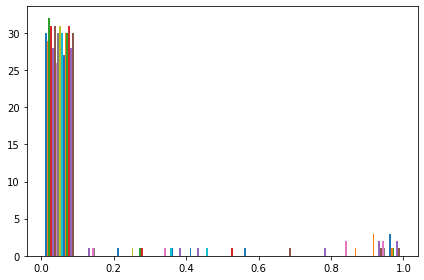

In [7]:
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)

axs.hist(hist_dat);

In [8]:
def exp_eval_e_ball(exp):
    exp["e_ball_args"] = defaults.check_and_fill_args(
        args=cox.utils.Parameters({
            "adv_eval": 0,
            "out_dir": ".results",
            "constraint": "inf",
            "eps": exp["perturb_eps"],
            "attack_lr": exp["attack_lr_scaling"] * exp["perturb_eps"] / exp["attack_steps"],
            "attack_steps": exp["attack_steps"]}),
        arg_list=defaults.PGD_ARGS,
        ds_class=datasets.CIFAR)
    class EBallLoader():
        def __init__(self, loader):
            self.loader = loader
        def __iter__(self):
            return self
        def __next__(self):
            return next(self.loader)
        def __len__(self):
            return len(self.loader)
    exp["e_ball_val_loader"] = EBallLoader(exp["val_loader"])
    exp["model"].eval()
    exp["e_ball_results"] = train.eval_model(
        model=exp["model"],
        args=exp["e_ball_args"],
        loader=exp["e_ball_val_loader"],
        store=exp["cox"])
    print(exp["e_ball_results"])

exp_eval_e_ball(CIFAR10)

  0%|          | 0/16 [00:00<?, ?it/s]

TypeError: 'DataLoader' object is not an iterator

In [ ]:
def exp_eval_finetune(exp):
    exp.update({
        "finetune_args": defaults.check_and_fill_args(
            args=cox.utils.Parameters({
                "adv_train": 1,
                "out_dir": ".results",
                "constraint": "inf",
                "eps": exp["perturb_eps"],
                "attack_lr": exp["attack_lr_scaling"] * exp["perturb_eps"] / exp["attack_steps"],
                "attack_steps": exp["attack_steps"]}),
            arg_list=defaults.PGD_ARGS,
            ds_class=datasets.CIFAR),
        "finetune_params": exp["model"].model.parameters()})
    exp["finetune_args"] = defaults.check_and_fill_args(
        defaults.check_and_fill_args(
            exp["finetune_args"],
            defaults.TRAINING_ARGS,
            datasets.CIFAR),
        defaults.PGD_ARGS,
        datasets.CIFAR)
    exp["model"].train()
    exp["finetune_results"] = train.train_model(
        model=exp["model"],
        update_params=exp["finetune_params"],
        args=exp["finetune_args"],
        loaders=(exp["train_loader"], exp["val_loader"]),
        store=exp["cox"])
    print(exp["finetune_results"])

exp_eval_finetune(CIFAR10)